In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import seaborn as sns
from Test import *
import math

In [233]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [234]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(100,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 1/10   #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients

tolerance=-1                #PDMM tolerance
c=0.5                       #PDMM c
max_iters=30000             #PDMM max iterations (not transmissions)

var = 30000                  # Standard deviation for Gaussian noise
mean = 200                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 5
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data



num_nodes: 100
IteNumber of Corrupt nodesration 10, Corrupt nodes: [67 42 21 79 88 95  6 47 45 73]


In [235]:
def is_anomaly(x,threshold):
    return x > threshold  

def normpdf(x, mn, var):
    denom = (2*math.pi*var)**.5
    num = math.exp((-(x - mn)**2) /(2*var + 1e-6))
    return num/(denom + 1e-6)

In [236]:
def main():
    avg_temp = np.mean(Data)
    for i in range(num_nodes):
        if CorruptClients[i] == 1:
                Data[i] = np.random.normal(mean,  np.sqrt(var))


    Error = []
    Error, Transmission,avg_temp = PDMM(Data, G, avg_temp, tolerance, c, max_iters)

    # plt.figure(figsize=(10, 6))
    # sns.heatmap(A, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('Connection Matrix Heatmap')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()

    print(avg_temp)
    
    plt.figure(figsize=(10, 4))
    # Plot accuracy
    plt.plot(range(len(Error)), Error, label='PDMM convergenc')
    plt.yscale('log')
    plt.title('PDMM erorr over tranmission rounds')
    plt.xlabel('Transmission Round')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [237]:
def PDMM( Data, G, avg_temp, tolerance, c, max_iters):
    # Create the histogram
    plt.figure(figsize=(6,4))
    plt.hist(Control, bins=20, edgecolor='black', alpha=0.7)
    plt.title("Distribution of data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])
    anomaly_list = set()
    #initialise A_ij
    A_ij=calc_incidence_nested(G)

    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))

    for i in np.arange(0,num_nodes):
        for j in G.neighbors(i):
            z[i][j]=0
            y[i][j]=0
            
    count=0
    while not converged and count < max_iters:
        #if count == 0:
            # plt.figure(figsize=(10, 6))
            # sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
            # plt.title('PDMM z Heatmap over Nodes Rounds')
            # plt.xlabel('Nodes')
            # plt.ylabel('Nodes')
            # plt.tight_layout()
            # plt.show()

        #update x_i and y_ij
        i = np.random.randint(0, num_nodes)
        #update x_i
        x[i]=Data[i]
        for j in G.neighbors(i):
            x[i]=x[i]-A_ij[i][j]*z[i][j]
        x[i]=x[i]/(1+c*G.degree(i))
        #update y_ij
        for j in G.neighbors(i):
            y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
        count = count + 1

        diff = x - avg_temp
        Error = np.append(Error, np.linalg.norm(diff))
        if np.linalg.norm(diff)< tolerance:
            print(f'Iteration {count}, Norm of difference: {Error:.8f}')
            converged = True
            
        print(f"G.degree(i): {G.degree(i)}")
        #update z_ij
        Burentelling_plus = 0
        Burentelling_min = 0
        mean_sum_minus = 0
        mean_sum_plus = 0
        var_sum_plus = 0
        var_sum_minus = 0
        
        for j in G.neighbors(i):
            if y[i][j] > 0:
                print("DIt is plus")
                Burentelling_plus =+ 1
                mean_sum_plus =+ y[j][i]
            else :
                print("DIt is min")
                Burentelling_min =+ 1
                mean_sum_minus =+ y[j][i]
        mean_estimate_plus = mean_sum_plus / (Burentelling_plus + 1e-6)
        mean_estimate_minus = mean_sum_minus / (Burentelling_min + 1e-6)

        for j in G.neighbors(i):
            if y[j][i] > 0: 
                var_sum_plus =+ (y[j][i] - mean_estimate_plus) ** 2
            else :
                var_sum_minus =+ (y[j][i] - mean_estimate_minus) ** 2
        var_estimate_plus = var_sum_plus / (Burentelling_plus - 1 + 1e-6)
        var_estimate_minus = var_sum_minus / (Burentelling_min - 1 + 1e-6)

        for j in G.neighbors(i):
            print(f"mean_estimate_plus: {mean_estimate_plus}, mean_estimate_minus: {mean_estimate_minus}")
            print(f"var_estimate_plus: {var_estimate_plus}, var_estimate_minus: {var_estimate_minus}")
            
            T_H0_plus = normpdf(y[j][i],mean_estimate_plus,var_estimate_plus)
            T_H0_min = normpdf(y[j][i],mean_estimate_minus,var_estimate_minus)

            print(f"T_H0_plus: {T_H0_plus}, T_H0_min: {T_H0_min}")
            if not is_anomaly(T_H0_plus, 0.95) or not is_anomaly(T_H0_min, 0.95):
                z[i][j]=y[j][i]
            else:
                anomaly_list.add((j))
                # print(f"Anomaly detected in data from node {j} to node {i}")

    print(f"Anomly list: {anomaly_list}")
    
        # for j in G.neighbors(i):
        #     z[i][j]=y[j][i]


    # test = 50
    # for j in G.neighbors(test):
    #     print(j)
    #     print(y[j][test])
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(y, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM y Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM z Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()
    

    # num_rows = y.shape[0]

    # # Create a figure with one subplot per row
    # fig, axes = plt.subplots(num_rows, 1, figsize=(6, 2 * num_rows))
    # for i in range(num_rows):
    #     non_zero_values = y[i, y[i, :] != 0]
        
    #     axes[i].hist(non_zero_values, bins=20, edgecolor='black', alpha=0.7)
    #     axes[i].set_title(f"Distribution of Non-Zero Values in Row {i}")
    #     axes[i].set_xlabel("Value")
    #     axes[i].set_ylabel("Frequency")

    # plt.tight_layout()
    # plt.show()

    all_values = y.flatten()

    # Exclude zeros
    non_zero_values = all_values[all_values != 0]

    # Create the histogram
    plt.figure(figsize=(6,4))
    plt.hist(non_zero_values, bins=20, edgecolor='black', alpha=0.7)
    plt.title("Distribution all transmitted variables")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
    return Error,count,avg_temp

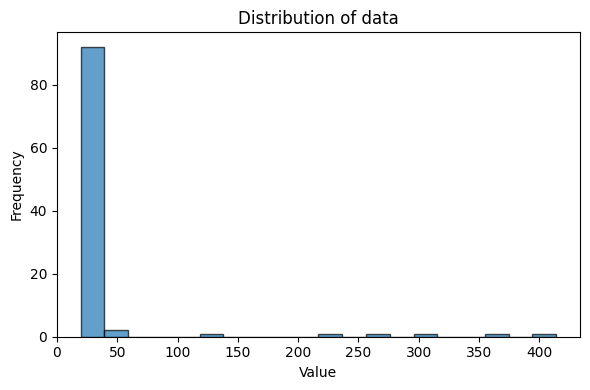

C:\Users\za_re\AppData\Local\Temp\ipykernel_35548\1768869984.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
C:\Users\za_re\AppData\Local\Temp\ipykernel_35548\3174633023.py:5: RuntimeWarning: invalid value encountered in scalar power
  denom = (2*math.pi*var)**.5


G.degree(i): 10
DIt is min
DIt is min
DIt is min
DIt is min
DIt is min
DIt is plus
DIt is plus
DIt is plus
DIt is plus
DIt is plus
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean_estimate_minus: 0.0
var_estimate_plus: 0.0, var_estimate_minus: 0.0
T_H0_plus: 1000000.0, T_H0_min: 1000000.0
mean_estimate_plus: 0.0, mean

OverflowError: math range error

In [238]:
if __name__ == '__main__':
    main()